# DreaMS-Fluorine

## 1. Obtain model weights

Please contact us at roman.bushuiev@uochb.cas.cz to request the DreaMS-Fluorine model weight files (`dreams_fluorine_epoch=1-step=7000.ckpt` and `dreams_fluorine_epoch=30-step=111000.ckpt`). After receiving them, place both files in `/DreaMS/dreams/models/pretrained/`.

Note that DreaMS-Fluorine was trained using NIST20, so we can share the weights only with NIST library license holders. Please attach your NIST license or order confirmation to the email.

## 2. Run DreaMS-Fluorine

Execute the following command, where `--in_dir` specifies the folder containing `.mzML` or `.mgf` files (here, `data/MSV000099559`). The script will generate `dreams_fluorine_predictions.csv` in the same folder, containing predicted fluorine-presence probabilities for each MS/MS spectrum in each file. The current model version supports positive-mode data only.

```bash
python3 dreams/cli.py dreams_fluorine --in_dir data/MSV000099559
```

## 3. Examine the predictions

In [2]:
import pandas as pd
df = pd.read_csv('../data/MSV000099559/dreams_fluorine_predictions.csv')
df

,RT,charge,file_name,polarity,precursor_mz,precursor_target_mz,scan_number,spectrum,window_lo,window_uo,F_preds_111k_steps,F_preds_7k_steps,dformat,tag
0,810.063540,1,MO23S_030.mzML,1,304.891639,304.891632,4153,"[[81.07015991210938, 83.0491714477539, 84.9596...",0.5,0.5,0.923519,0.210867,A,Only 111k checkpoint > 0.9 hit
1,34.545791,1,MO23S_030.mzML,1,241.999878,241.999878,133,"[[81.07012939453125, 84.95979309082031, 84.964...",0.5,0.5,0.921477,0.217751,A,Only 111k checkpoint > 0.9 hit
2,514.087512,1,MO23S_030.mzML,1,204.138540,204.138535,2640,"[[78.58903503417969, 79.05422973632812, 84.044...",0.5,0.5,0.913897,0.604710,A,Only 111k checkpoint > 0.9 hit
3,810.776700,1,MO23S_027.mzML,1,328.915390,328.915405,4179,"[[81.06999206542969, 87.28488159179688, 90.947...",0.5,0.5,0.903643,0.140945,A,Only 111k checkpoint > 0.9 hit
4,809.980320,1,MO23S_027.mzML,1,304.891539,304.891541,4175,"[[84.95977783203125, 85.2956314086914, 90.0553...",0.5,0.5,0.878663,0.227668,A,Only 111k checkpoint > 0.75 hit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11125,745.386000,2,MO23S_027.mzML,1,615.455358,615.455383,3859,"[[79.05448150634766, 80.05440521240234, 81.069...",0.5,0.5,0.000000,0.000000,A,NaN
11126,745.794840,2,MO23S_027.mzML,1,593.442417,593.442444,3861,"[[80.05455780029297, 81.06998443603516, 83.085...",0.5,0.5,0.000000,0.000000,A,NaN
11127,747.321360,2,MO23S_027.mzML,1,571.429528,571.429504,3868,"[[80.05457305908203, 81.06989288330078, 83.085...",0.5,0.5,0.000000,0.000000,A,NaN
11128,748.533720,2,MO23S_027.mzML,1,549.416251,549.416260,3874,"[[80.05448150634766, 81.06990814208984, 81.132...",0.5,0.5,0.000000,0.000000,A,NaN


The prediction file contains standard metadata parsed from the input files, such as retention time (`RT`) and precursor m/z (`precursor_mz`), which can be used to reference the input spectra. In addition, it includes DreaMS-Fluorine predictions in the columns `F_preds_111k_steps` and `F_preds_7k_steps`. These columns represent fluorine presence probabilities predicted by two versions of the DreaMS-Fluorine model trained for different numbers of steps.

We consider a prediction to be confident if both models predict a fluorine probability of at least 0.75. Such cases are annotated in the `tag` column as `> 0.75 hit`, `> 0.9 hit`, or `> 0.95 hit`, depending on the prediction scores. Less confident predictions are labeled as `Only 111k checkpoint > 0.75 hit`, `Only 111k checkpoint > 0.9 hit`, or `Only 111k checkpoint > 0.95 hit`, indicating that only the model trained for 111k steps produced a confident prediction.

We further classify spectra into low- and high-quality categories (see [Fig. 2b](https://www.nature.com/articles/s41587-025-02663-3/figures/2)). If a spectrum is of low quality but still yields a confident prediction, the model may be hallucinating the result (for example, for spectra containing only a single signal). Such cases are therefore marked with a `Low quality` prefix in the `tag` column. If the `tag` value is NaN, the spectrum is not predicted to correspond to a fluorinated molecule.

The plot below summarizes these tags for three files from the example [MSV000099559](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=47c76080c5f345ed938f1ccc9234c7e0) dataset. While there are no highly confident predictions supported by both models, there are 18 predictions of fluorinated molecules supported by only one of the models (corresponding to the last two rows in the heatmap).

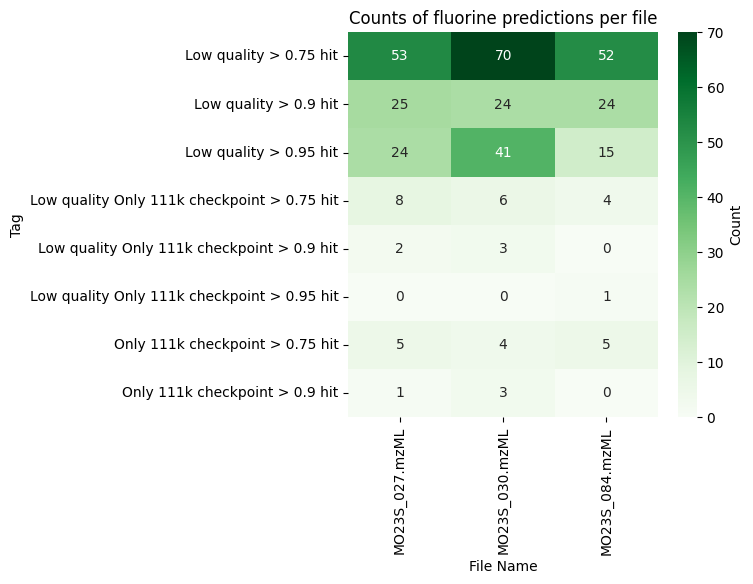

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df[df['tag'] != '']
tag_file_counts = df_plot.pivot_table(index='tag', columns='file_name', values='RT', aggfunc='count', fill_value=0)
plt.figure(figsize=(5, 5))
sns.heatmap(tag_file_counts, annot=True, fmt='d', cmap='Greens', cbar_kws={'label': 'Count'})
plt.xlabel('File Name')
plt.ylabel('Tag')
plt.title('Counts of fluorine predictions per file')
plt.show()